# Harjoitustyö, TLO-32410 Johdanto datatieteeseen

Aleksi Lehmus, aleksi.lehmus@tuni.fi

## Yleistä

Tässä harjoitustyössä käsittelen viimeisen vuoden aikana toteutuneita asuntokauppoja Tampereella ja pyrin ennustamaan reiluja hintoja uusille myytäville kohteille.

In [572]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

Ladataan Scrapylla kerätty datasetti käsiteltäväksi

In [573]:
data = pd.read_csv("out.csv")

## Datan jalostaminen

In [574]:
data.head()

,Kaupunginosa,Huoneisto,Talotyyppi,Neliömäärä,Velaton hinta,Euroa per neliö,Rakennusvuosi,Kerros,Hissi,Kunto,Energialuokka
0,Tasanne,autop. katoksessa,kt,"1,00",6000,6000,2019,1/1,ei,hyvä,A
1,Ristinarkku,"1h,k",kt,"28,00",133800,4779,2019,4/7,on,hyvä,"C,2013"
2,Hervanta,"1 h, keittokome...",kt,"35,50",96000,2704,1985,1/6,on,hyvä,NaN
3,Kaakinmaa,Autohalli,kt,"13,00",30000,2308,2018,-1/10,on,hyvä,C
4,Lentävänniemi,AUTOKATOS,kt,"20,00",4500,225,2019,1/6,on,hyvä,"C,2013"


In [575]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 11 columns):
Kaupunginosa       1271 non-null object
Huoneisto          1269 non-null object
Talotyyppi         1271 non-null object
Neliömäärä         1271 non-null object
Velaton hinta      1271 non-null int64
Euroa per neliö    1271 non-null int64
Rakennusvuosi      1271 non-null int64
Kerros             1271 non-null object
Hissi              1271 non-null object
Kunto              1271 non-null object
Energialuokka      926 non-null object
dtypes: int64(3), object(8)
memory usage: 109.3+ KB


Muutetaan lukuarvoksi ja poistetaan alle 10 neliön kaupat

In [576]:
data["Neliömäärä"] = data["Neliömäärä"].apply(lambda x: None if float(x.replace(",", ".")) < 10 
                                              else float(x.replace(",", ".")))
data = data[data["Neliömäärä"].notnull()]

Poistetaan Energialuokka piirteenä sen monimutkaisen esitystavan vuoksi

In [577]:
data.drop("Energialuokka", axis=1, inplace=True)

Poistetaan datasetistä helposti tunnistettavat autopaikkakaupat

In [578]:
data["Huoneisto"] = data["Huoneisto"].apply(lambda x: None if "auto" in str(x).lower() else str(x))
data = data[data["Huoneisto"].notnull()]

Tehdään hissistä binäärimuuttuja

In [579]:
data["Hissi"] = data["Hissi"].apply(lambda x: 1 if str(x) == "on" else 0)

Huomataan, että asunnon kunto sisältää paljon tyhjiä arvoja. Muutetaan arvot numeerisiksi

In [580]:
Counter(data["Kunto"])

Counter({'hyvä': 986, '\xa0': 116, 'tyyd.': 127, 'huono': 11})

In [581]:
data["Kunto"] = data["Kunto"].apply(lambda x: 1 if str(x) == "hyvä" 
                                    else (2 if str(x) == "tyyd." else (3 if str(x) == "huono" else 0)))

Poistetaan rivit, joilla ei ole kerrostietoa. Luodaan riveille uusi muuttuja esittämään suhteellinen kerrosluku

In [582]:
data = data[data["Kerros"] != "\xa0"]

In [583]:
def add_kerros_suht(row):
    kerros = str(row["Kerros"]).split("/")[0]
    kerrosmäärä = str(row["Kerros"]).split("/")[1]
    if int(kerros) in [-1, 0, 1]:
        row["Kerros_suht"] = "Alin kerros"
    elif kerros == kerrosmäärä:
        row["Kerros_suht"] = "Ylin kerros"
    else:
        row["Kerros_suht"] = "Keskikerros"
        
    return row

data = data.apply((lambda x: add_kerros_suht(x)), axis=1)

In [584]:
data = pd.concat([data, pd.get_dummies(data["Kerros_suht"])], axis=1)

In [585]:
data.drop("Kerros_suht", axis=1, inplace=True)

Muokataan kerrostieto absoluuttiseksi kerrosluvuksi, jotta sitä voidaan käsitellä numeerisesti

In [586]:
data["Kerros"] = data["Kerros"].apply(lambda x: str(x).split("/")[0])
data["Kerros"] = data["Kerros"].apply(lambda x: int(x))

In [587]:
data.dropna(inplace=True)

Datasetti näyttää nyt suunnilleen toivotulta

In [588]:
data.head()

,Kaupunginosa,Huoneisto,Talotyyppi,Neliömäärä,Velaton hinta,Euroa per neliö,Rakennusvuosi,Kerros,Hissi,Kunto,Alin kerros,Keskikerros,Ylin kerros
1,Ristinarkku,"1h,k",kt,28.0,133800,4779,2019,4,1,1,0,1,0
2,Hervanta,"1 h, keittokome...",kt,35.5,96000,2704,1985,1,1,1,1,0,0
5,Tesoma,"1H+KT+parvi 5,5 m²",kt,20.5,118000,5756,2018,6,1,1,0,0,1
6,Niemenranta,"1h,tk,alk",kt,33.0,139000,4212,2015,6,1,1,0,1,0
7,Tesoma,"h, kt, kph, las...",kt,23.0,96000,4174,2018,4,1,1,0,1,0


## Kunnon ennustaminen

Oletetaan kunnon vaikuttavan ratkaisevasti asunnon hintaan, eikä haluta poistaa yli sataa riviä, joilla kuntoa ei ole kerrottu. Joten ennustetaan myydyn asunnon oletettu kunto muiden toteutuneiden kauppojen perusteella.

In [589]:
Counter(data["Kunto"])

Counter({1: 983, 0: 116, 2: 124, 3: 11})

Valitaan merkittäviksi koetut attribuutit uuteen datasettiin, josta erotellaan opetusdataksi kaikki rivit, joissa kunto on, ja kohdedataksi kunnottomat

In [590]:
data2 = data[["Euroa per neliö", "Rakennusvuosi", "Hissi", "Kerros", "Kunto"]]

In [591]:
data_learn = data2[data2["Kunto"] != 0]
data_target = data2[data2["Kunto"] == 0]

Valitaan X = selittävät ominaisuudet ja y = ennustettava ominaisuus (kunto)

In [592]:
X = data_learn.drop("Kunto", axis=1)
y = data_learn["Kunto"]

Normalisoidaan numeeriset muuttujat

In [593]:
def normalize(data):
    dataMean = np.mean(data, axis=0)
    dataDev = np.std(data, axis=0)
    norm_x = (data - dataMean) / dataDev
    return norm_x

In [594]:
X_norm = normalize(X)

In [595]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.20, random_state=42)

Valitaan scikit-learnin Cheat Sheetin suosittelemana SVC luokittelumalliksi ja opetetaan se harjoitusdatalla

In [596]:
model = SVC()

In [597]:
model.fit(X = X_train, y = y_train)

/Users/aleksilehmus/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Ennustetaan kunnot X_testistä ja luetaan luokitteluraportti

In [598]:
preds = model.predict(X_test)

In [599]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.91      1.00      0.95       203
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00         1

   micro avg       0.91      0.91      0.91       224
   macro avg       0.30      0.33      0.32       224
weighted avg       0.82      0.91      0.86       224



/Users/aleksilehmus/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [600]:
print(confusion_matrix(y_test, preds))

[[203   0   0]
 [ 20   0   0]
 [  1   0   0]]


In [601]:
preds_target = model.predict(data_target.drop("Kunto", axis=1))
preds_target

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

Huomataan, että malli luokitteli kaikki tapaukset hyväkuntoisiksi (y=1). Tämä on kuitenkin ymmärrettävää, sillä hyväkuntoiset dominoi dataa, eikä huonokuntoisia esimerkiksi ollut harjoitusdatassa ollenkaan

In [602]:
y_train.head()

648     1
824     1
485     2
1036    1
1102    1
Name: Kunto, dtype: int64

Lisätään ennustetut kunto-arviot target-datasettiin

In [603]:
data_target["Kunto"] = preds_target

/Users/aleksilehmus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Nyt hyväksytyllä luokittelijoilla ennustetaan oikean datasetin jokaiselta 0-kuntoriviltä muita ominaisuuksia tukeva kunto-arvio ja lisätään se kunnon paikalle.

In [604]:
def add_predictions(row):
    if row["Kunto"] == 0:
        row["Kunto"] = model.predict(pd.DataFrame(row[["Euroa per neliö", "Rakennusvuosi", "Hissi", "Kerros"]]).T)[0]
        
    return row

data = data.apply((lambda x: add_predictions(x)), axis=1)

Nyt datassa ei ole enää tyhjiä kunto-arvioita

In [605]:
Counter(data["Kunto"])

Counter({1: 1099, 2: 124, 3: 11})

Kopioidaan uusi "puhdas" datasetti erilleen ja tehdään kuntoluokista dummy-arvot

In [606]:
data_clean = data

In [607]:
data_clean = pd.concat([data_clean, pd.get_dummies(data_clean["Kunto"])], axis=1)
data_clean.drop("Kunto", axis=1, inplace=True)
data_clean.rename(columns={1: "Hyvä kunto", 2: "Tyyd. kunto", 3: "Huono kunto"}, inplace=True)

In [608]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1234 entries, 1 to 1270
Data columns (total 15 columns):
Kaupunginosa       1234 non-null object
Huoneisto          1234 non-null object
Talotyyppi         1234 non-null object
Neliömäärä         1234 non-null float64
Velaton hinta      1234 non-null int64
Euroa per neliö    1234 non-null int64
Rakennusvuosi      1234 non-null int64
Kerros             1234 non-null int64
Hissi              1234 non-null int64
Alin kerros        1234 non-null int64
Keskikerros        1234 non-null int64
Ylin kerros        1234 non-null int64
Hyvä kunto         1234 non-null uint8
Tyyd. kunto        1234 non-null uint8
Huono kunto        1234 non-null uint8
dtypes: float64(1), int64(8), object(3), uint8(3)
memory usage: 128.9+ KB


## Datan kuvaileminen

In [609]:
data_clean.head()

,Kaupunginosa,Huoneisto,Talotyyppi,Neliömäärä,Velaton hinta,Euroa per neliö,Rakennusvuosi,Kerros,Hissi,Alin kerros,Keskikerros,Ylin kerros,Hyvä kunto,Tyyd. kunto,Huono kunto
1,Ristinarkku,"1h,k",kt,28.0,133800,4779,2019,4,1,0,1,0,1,0,0
2,Hervanta,"1 h, keittokome...",kt,35.5,96000,2704,1985,1,1,1,0,0,1,0,0
5,Tesoma,"1H+KT+parvi 5,5 m²",kt,20.5,118000,5756,2018,6,1,0,0,1,1,0,0
6,Niemenranta,"1h,tk,alk",kt,33.0,139000,4212,2015,6,1,0,1,0,1,0,0
7,Tesoma,"h, kt, kph, las...",kt,23.0,96000,4174,2018,4,1,0,1,0,1,0,0


Varmistetaan, että datan lukuarvot ovat järkeviä, eivätkä sisällä mallia sekoittavia outliereita.

In [610]:
data_clean.describe()

,Neliömäärä,Velaton hinta,Euroa per neliö,Rakennusvuosi,Kerros,Hissi,Alin kerros,Keskikerros,Ylin kerros,Hyvä kunto,Tyyd. kunto,Huono kunto
count,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000
mean,47.782334,151613.944895,3377.700162,1993.484603,3.322528,0.760940,0.193679,0.626418,0.179903,0.890600,0.100486,0.008914
std,18.935105,71867.737562,1219.916695,27.160993,1.969688,0.426682,0.395341,0.483951,0.384262,0.312267,0.300769,0.094031
min,12.500000,1800.000000,144.000000,1899.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,107038.250000,2500.000000,1970.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,45.500000,135475.000000,3413.500000,2005.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,62.000000,175000.000000,4187.000000,2018.000000,5.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,123.000000,715000.000000,7395.000000,2020.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Tarkistetaan arvojen jakaumat

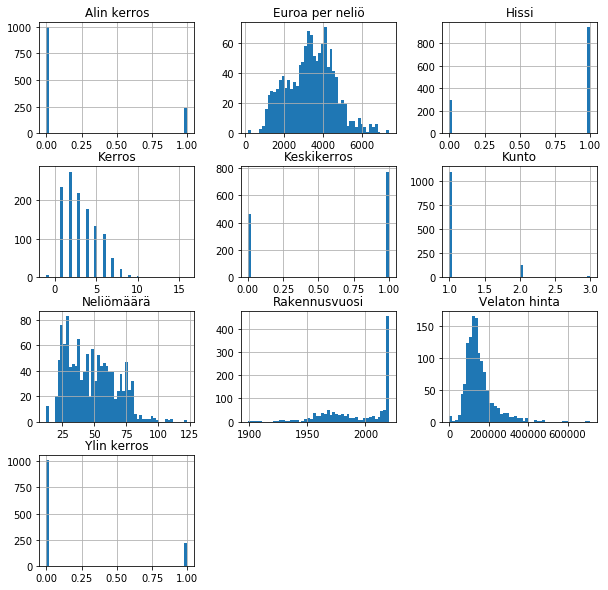

In [611]:
data.hist(bins=50, figsize=(10,10))
plt.show()

Lasketaan ja visualisoidaan datan piirteiden vaikutukset velattomaan hintaan

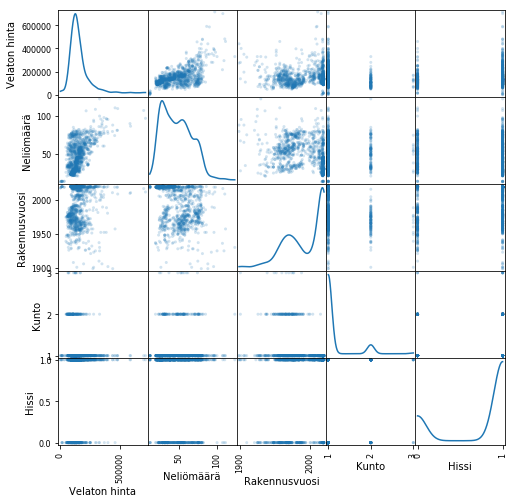

In [612]:
scatter_feats = data[["Velaton hinta", "Neliömäärä", "Rakennusvuosi", "Kunto", "Hissi"]]
pd.plotting.scatter_matrix(scatter_feats, alpha=0.2, figsize=(8, 8), diagonal='kde')
plt.show()

In [613]:
scatter_feats.corr(method='pearson')

,Velaton hinta,Neliömäärä,Rakennusvuosi,Kunto,Hissi
Velaton hinta,1.000000,0.566950,0.043445,-0.160187,0.168757
Neliömäärä,0.566950,1.000000,-0.360603,0.050948,-0.066134
Rakennusvuosi,0.043445,-0.360603,1.000000,-0.336898,0.306798
Kunto,-0.160187,0.050948,-0.336898,1.000000,-0.065767
Hissi,0.168757,-0.066134,0.306798,-0.065767,1.000000


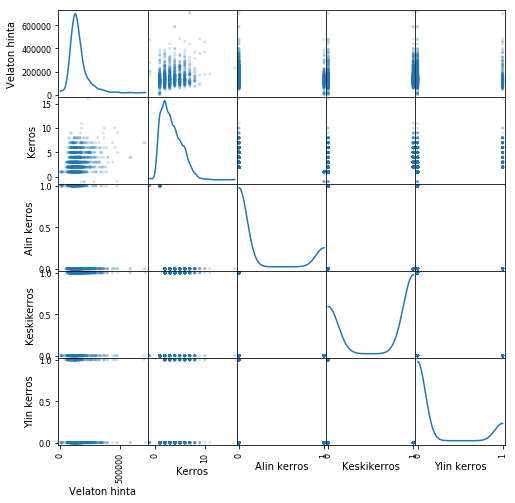

In [614]:
scatter_feats2 = data[["Velaton hinta", "Kerros", "Alin kerros", "Keskikerros", "Ylin kerros"]]
pd.plotting.scatter_matrix(scatter_feats2, alpha=0.2, figsize=(8, 8), diagonal='kde')
plt.show()

In [615]:
scatter_feats2.corr(method='pearson')

,Velaton hinta,Kerros,Alin kerros,Keskikerros,Ylin kerros
Velaton hinta,1.000000,0.193513,-0.127290,0.112853,-0.011171
Kerros,0.193513,1.000000,-0.588547,0.263487,0.273672
Alin kerros,-0.127290,-0.588547,1.000000,-0.634639,-0.229548
Keskikerros,0.112853,0.263487,-0.634639,1.000000,-0.606493
Ylin kerros,-0.011171,0.273672,-0.229548,-0.606493,1.000000


In [616]:
data_clean[["Velaton hinta", "Hyvä kunto", "Tyyd. kunto", "Huono kunto"]].corr(method='pearson')

,Velaton hinta,Hyvä kunto,Tyyd. kunto,Huono kunto
Velaton hinta,1.000000,0.166056,-0.158597,-0.044166
Hyvä kunto,0.166056,1.000000,-0.953633,-0.270592
Tyyd. kunto,-0.158597,-0.953633,1.000000,-0.031698
Huono kunto,-0.044166,-0.270592,-0.031698,1.000000


Huomataan, että *neliömäärä* vaikuttaa eniten velattomaan hintaan. Myös *hissi*, *kunto* ja *kerros* vaikuttavat jonkin verran. Kattohuoneisto ja Rakennusvuosi vaikuttavat yllättävän vähän

## Hintojen ennustaminen

Valitaan ennustemalleiksi lineaarinen regressio sekä neuroverkko

In [618]:
model_LR = LinearRegression()

In [619]:
model_MLP = MLPRegressor(hidden_layer_sizes=(100, 100, 100))

Valitaan ja normalisoidaan muuttujat ja ennustettava arvo (velaton hinta)

In [620]:
X = data_clean.drop(
    ["Kaupunginosa", "Huoneisto", "Talotyyppi", "Velaton hinta", "Euroa per neliö", "Kerros"], axis=1)
X_norm = normalize(X)
y = data_clean["Velaton hinta"]

In [624]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.20, random_state=42)

Fitataan mallit harjoitusdatalla

In [625]:
model_LR.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [626]:
model_MLP.fit(X_train, y_train)

/Users/aleksilehmus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [627]:
preds_LR = model_LR.predict(X_test)

In [628]:
preds_MLP = model_MLP.predict(X_test)

Arvioidaan ennustemallin suorituskykyä plottaamalla

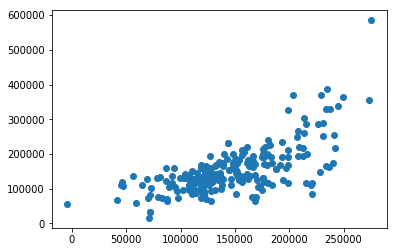

In [630]:
plt.scatter(preds_LR, y_test)

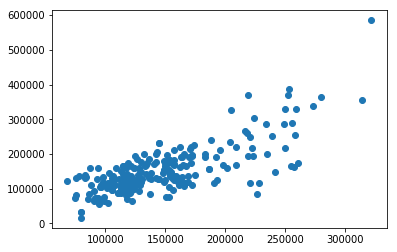

In [631]:
plt.scatter(preds_MLP, y_test)

## Hintalaskuri

Syötä myytävän asunnon parametrit alle, niin mallit laskevat historiadataan perustuvan reilun hinnan

In [653]:
Neliömäärä = 47 
Rakennusvuosi = 1950
# 1 jos on, 0 jos ei
Hissi = 1 
Alin_kerros = 0
Keskikerros = 1
Ylin_kerros = 0
Hyvä_kunto = 1
Tyyd_kunto = 0
Huono_kunto = 0

In [654]:
temp = normalize([Neliömäärä, Rakennusvuosi, Hissi, Alin_kerros, Keskikerros,
                  Ylin_kerros, Hyvä_kunto, Tyyd_kunto, Huono_kunto])

In [658]:
print(model_LR.predict([temp])[0])

175994.45603694537


In [659]:
print(model_MLP.predict([temp])[0])

203907.85517597126
